In [1]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

import plotly.express as px
import plotly.graph_objects as go

from fenginering.function import *
from fenginering.indicator import *
from fenginering.transformer import *
from fenginering.preprocessing import Crossover
from fenginering.preprocessing import Scale
from data.get_data import *


%load_ext autoreload
%autoreload 2

In [2]:
start = "2017"
end = "2023"
data = get_data('TWT', '1h').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

(19397, 5)

In [3]:
def get_classification_target(data):
    data = data.copy()
    data['returns'] = data["close"].pct_change()
    data['target'] = data['returns'].rolling(3).mean().shift(-1)
    #data['target'] = data['returns'].shift(-1)
    data['target'] = np.where(data['target'] > 0, 1, 0)
    return data['target']


#data['target'] = get_classification_target(data)
#data = data.iloc[:-1]

In [4]:
data['returns'] = data.close.pct_change()
data.dropna(inplace=True)
data['target'] = data['returns'].rolling(3).mean()
data['target'] = data['target'].shift(-2)
data.dropna(inplace=True)

data['target'] = np.where(data['target'] > 0, 1, 0)

data

,open,high,low,close,volume,returns,target
time,,,,,,,
2021-01-27 09:00:00,0.2888,0.2911,0.2500,0.2874,14823313.82,-0.004848,0
2021-01-27 10:00:00,0.2874,0.2930,0.2713,0.2795,7620084.30,-0.027488,0
2021-01-27 11:00:00,0.2804,0.2850,0.2603,0.2614,6634568.29,-0.064758,1
2021-01-27 12:00:00,0.2615,0.2682,0.2508,0.2561,6227202.13,-0.020275,1
2021-01-27 13:00:00,0.2566,0.2853,0.2540,0.2797,7169204.80,0.092152,1
...,...,...,...,...,...,...,...
2023-04-15 20:00:00,1.2397,1.2403,1.2354,1.2365,98954.00,-0.002501,1
2023-04-15 21:00:00,1.2363,1.2399,1.2329,1.2382,67976.00,0.001375,1
2023-04-15 22:00:00,1.2381,1.2442,1.2370,1.2425,71836.00,0.003473,1


In [5]:
lag_ret_list = [1, 3, 5, 9, 15, 30]
ema_list = [3, 9, 15]
rsi_list = [10, 14, 20]

atr_list = [5, 10, 20]

macd_dict = {
    'slow' : [10, 14],
    'fast' : [3, 5],
    'signal' : [2, 3]
}

sar_dict = {
    'step' : [0.2],
    'max_step' : [0.2]
}

stochastic_oscillator_dict = {
    'k_period' : [10, 15, 20],
    'd_period' : [3, 5]
}

Indicators = MakeIndicator(data)

Indicators.set_stransformer(lag_returns, lag_ret_list)
Indicators.set_stransformer(rsi, rsi_list)
Indicators.set_mtransformer(stochastic_oscillator, stochastic_oscillator_dict)
Indicators.set_stransformer(atr, atr_list)

data = Indicators.get_data()
n_drop = Indicators.na_count
        
norm_scale = Scale(data)
data = norm_scale.transform()

<AxesSubplot: >

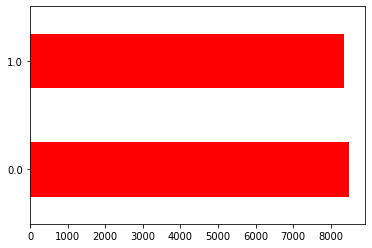

In [6]:
N = data.shape[0]
n = int(0.7*N)
train = data.loc["2021":"2022"]
test = data.loc["2023"]

features, target = train.drop(columns = ['target']), train['target']
features_test, target_test = test.drop(columns = ['target']), test['target']


target.value_counts().plot(kind = 'barh', color = 'red')

In [7]:
from model import *

proba_data = fit(models, features, target, features_test, target_test)

LogisticRegression


c:\Users\cc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Accuracy : 0.66 
 f1 : 0.65 
 precision : 0.66 
 recall : 0.65 
 AUC : 0.71 
    -      -    -
    -      -    -
RandomForestClassifier
 Accuracy : 0.68 
 f1 : 0.66 
 precision : 0.70 
 recall : 0.63 
 AUC : 0.75 
    -      -    -
    -      -    -
XGBClassifier
 Accuracy : 0.67 
 f1 : 0.65 
 precision : 0.68 
 recall : 0.62 
 AUC : 0.73 
    -      -    -
    -      -    -


In [8]:
px.box(pd.DataFrame(proba_data))

In [9]:
models

[('LogisticRegression', LogisticRegression()),
 ('RandomForestClassifier', RandomForestClassifier()),
 ('XGBClassifier',
  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='',
                learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
                max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
                missing=nan, monotone_constraints='()', n_estimators=100,
                n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
                reg_alpha=0, reg_lambda=1, ...))]

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

exp_cv = TimeSeriesSplit(n_splits = 10)

model = RandomForestClassifier()
model.fit(features, target)

#cross_val_score(model, features, target, cv = exp_cv)

RandomForestClassifier()

 Accuracy : 0.68 
 f1 : 0.66 
 precision : 0.70 
 recall : 0.63 
 AUC : 0.74 
              precision    recall  f1-score   support

         0.0       0.67      0.74      0.70      1265
         1.0       0.70      0.63      0.66      1255

    accuracy                           0.68      2520
   macro avg       0.68      0.68      0.68      2520
weighted avg       0.68      0.68      0.68      2520



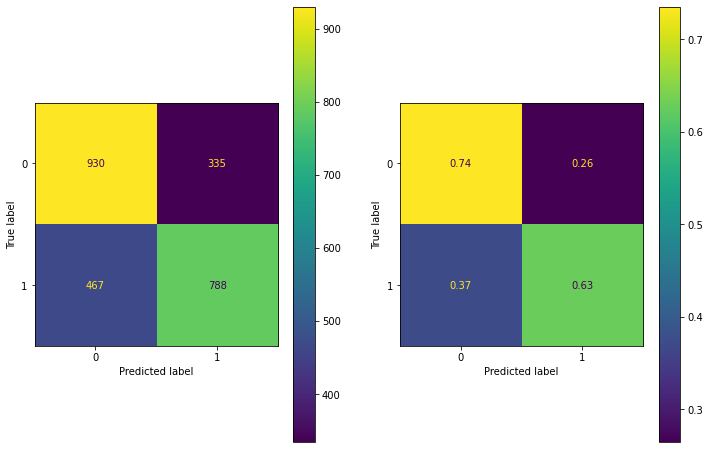

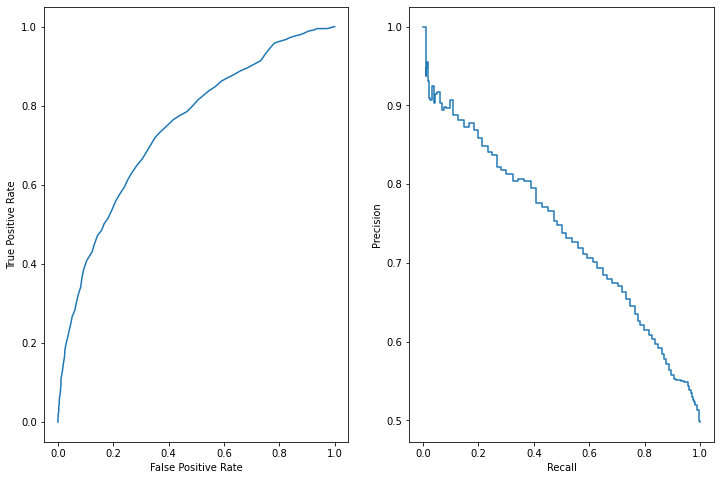

In [11]:
y_pred = model.predict(features_test)
y_pred_proba = model.predict_proba(features_test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()

In [12]:
def backtest(features_test, target_test):
    backtest = pd.DataFrame()
    #backtest['returns'] = features_test.close.pct_change()
    backtest['returns'] = features_test.ret_1_0
    backtest['target'] = target_test
    backtest['pred'] = y_pred

    backtest['cum_ret'] = (1 + backtest['returns']).cumprod()

    backtest['strategy'] = backtest['returns']*backtest['pred']
    backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()
    
    backtest[['cum_ret', 'strategy_cum_ret']].plot(figsize = (15, 10))

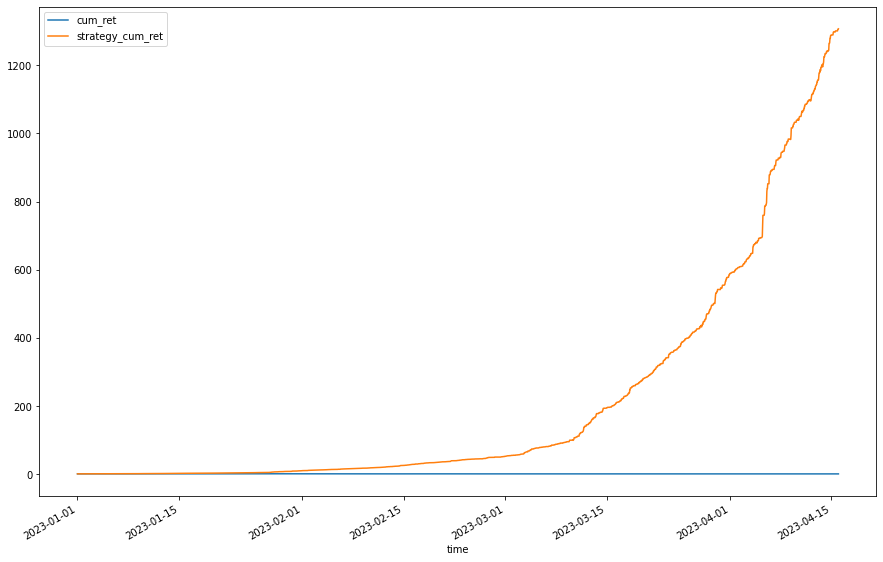

In [13]:
backtest(features_test, target_test)

In [14]:
import joblib
#joblib.dump(model, 'model_file/test_00.joblib')
joblib.dump(model, 'model_file/test_1d.joblib')

['model_file/test_1d.joblib']

In [16]:
target_test.value_counts()

0.0    1265
1.0    1255
Name: target, dtype: int64